# Umsetzung Q-Agent mit Ideen aus Paper von Vos und Sabatelli
3 verschiedene Exploaration Policies:
- greedy
- e-greedy
- softmax
Hyperparameter:
- learning rate (alpha) = 0,4
- discount factor (gamma) = 0,9
- epochs = 1 Mio
- epsilon = 0,05 (gibt Variante mit epsilon decay bis e = 0, wobei e = e - E/Anzahl Epochen)
Rewards:
- Verlieren = -0,5
- Gewinnen = 4
- Hit ohne bust = 2
Es werden jeweils 50 Agenten trainiert und das Ergebnis gemittelt

In [1]:
from blackjackenv import BlackjackEnv
import qagent
from qagent import QAgent
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gymnasium as gym

In [2]:
# hyperparameters
learning_rate = 0.001
n_episodes = 100_000 # nach Vos 1_000_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0
gamma = 0.95

def initiate_agents(number_of_agents, exp_policy, learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma):
    agents = []
    
    for i in range(0,number_of_agents):
        agent = QAgent(
            exp_policy=exp_policy,
            alpha=learning_rate,
            initial_epsilon=start_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon,
            gamma=gamma
        )
        agents.append(agent)
    return agents

In [16]:
softmax_agents = initiate_agents(50, "softmax", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [17]:
greedy_agents = initiate_agents(50, "greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [18]:
e_greedy_agents = initiate_agents(50, "e_greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [19]:
def train_agents(agents):
    envs = []
    for agent in agents:
        env = BlackjackEnv(sab=True, win_reward=1.0, lose_reward=-1.0, hit_reward=0.1)
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
    
            # play one episode
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
    
                # update the agent
                agent.update(state, action, reward, terminated, next_state)
    
                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state
    
            agent.decay_epsilon()
        envs.append(env)
    return envs

In [20]:
envs_softmax = train_agents(softmax_agents)
envs_greedy = train_agents(greedy_agents)
envs_e_greedy = train_agents(e_greedy_agents)

 66%|██████▋   | 66456/100000 [00:04<00:02, 14534.97it/s]


KeyboardInterrupt: 

In [8]:
def calculate_avg_reward(envs, rolling_length):
    rolling_length = rolling_length
    avg = []
    for env in envs:
        reward_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        avg.append(reward_average)
    
    avg_50_agents_100_games = []
    for i in range(len(avg[0])):
        a = []
        for j in range(len(avg)):
            m = avg[j][i]
            a.append(m)
        avg_50_agents_100_games.append(np.mean(a))
    
    return avg_50_agents_100_games

In [9]:
softmax_rewards = calculate_avg_reward(envs_softmax, 10_000)
greedy_rewards = calculate_avg_reward(envs_greedy, 10_000)
e_greedy_rewards = calculate_avg_reward(envs_e_greedy, 10_000)

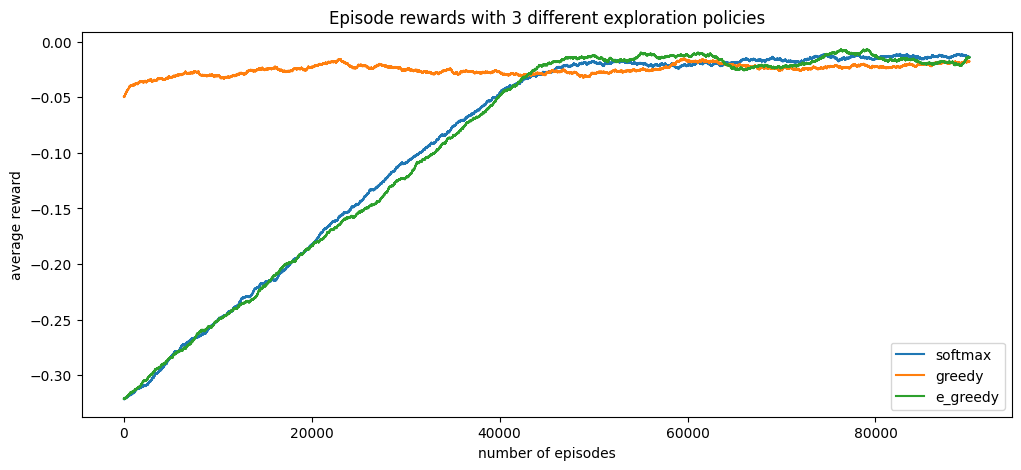

In [10]:
fig, axs = plt.subplots(figsize=(12, 5))
axs.set_title("Episode rewards with 3 different exploration policies")
axs.plot(range(len(softmax_rewards)), softmax_rewards, label = "softmax")
axs.plot(range(len(greedy_rewards)), greedy_rewards, label = "greedy")
axs.plot(range(len(e_greedy_rewards)), e_greedy_rewards, label = "e_greedy")
plt.legend()
plt.xlabel("number of episodes")
plt.ylabel("average reward")
plt.show()

In [11]:
a = [e_greedy_agents, greedy_agents, softmax_agents]
wins = []
for agents in a:
    env = BlackjackEnv(sab=True, win_reward=1.0, lose_reward=-1.0, hit_reward=0.1)
    random_agents = np.random.choice(agents, size=3)
    for random_agent in random_agents:
        agent = random_agent
        win = 0
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
        
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
            
                done = terminated or truncated
                state = next_state
                if reward >= 1.0:
                    win += 1
        wins.append(win)

100%|██████████| 100000/100000 [00:04<00:00, 24737.99it/s]


In [12]:
policies = ["e_greedy", "greedy", "softmax"]
for i in range(0,9,3):
    policy = policies[int(i/3)]
    sum = 0
    for j in range(i,3+i):
        sum = sum + (wins[j]/n_episodes)
    avg = sum/3
    print("{} : {}%".format(policy,avg*100))

e_greedy : 42.48133333333333%
greedy : 42.25000000000001%
softmax : 42.220666666666666%


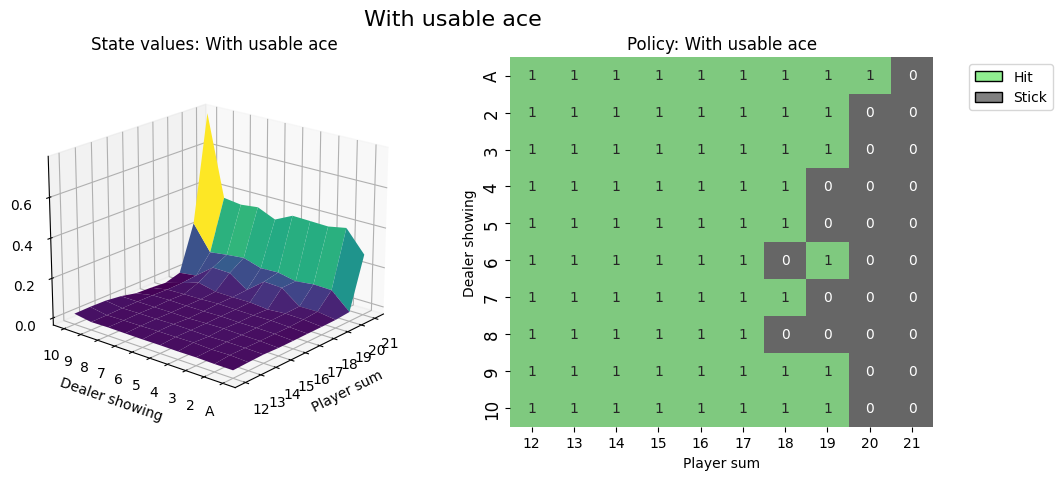

In [14]:
greedy_agent = greedy_agents[2]

# state values & policy with usable ace
value_grid, policy_grid = qagent.create_grids(greedy_agent, usable_ace=True)
fig1 = qagent.create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

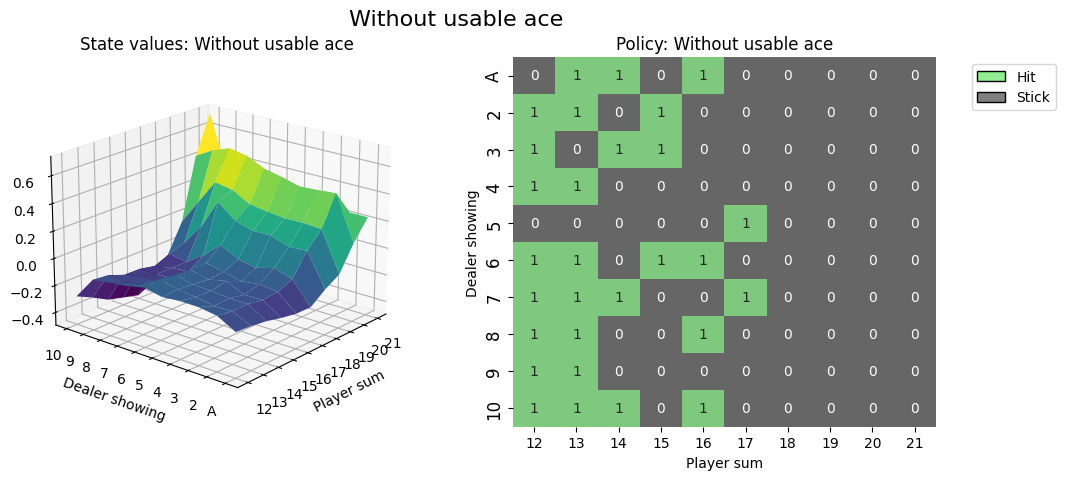

In [15]:
value_grid, policy_grid = qagent.create_grids(greedy_agent, usable_ace=False)
fig2 = qagent.create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
e_greedy_agent = e_greedy_agents[43]

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = qagent.create_grids(e_greedy_agent, usable_ace=True)
fig1 = qagent.create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
value_grid, policy_grid = qagent.create_grids(e_greedy_agent, usable_ace=False)
fig2 = qagent.create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
softmax_agent = softmax_agents[28]

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = qagent.create_grids(softmax_agent, usable_ace=True)
fig1 = qagent.create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

In [ ]:
value_grid, policy_grid = qagent.create_grids(softmax_agent, usable_ace=False)
fig2 = qagent.create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## Verschiedene Rewards ausprobieren

### Hit Rewards testen

In [26]:
learning_rate = 0.001
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) 
final_epsilon = 0
discount_factor = 0.95

agent = QAgent(
    exp_policy="e_greedy",
    alpha=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma=discount_factor
)

reward_envs = []

for i in range(0,10):
    j = 0.1
    j = j + 0.1
    env = BlackjackEnv(sab=True, win_reward=1.0, lose_reward=-1.0, hit_reward=j)
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    reward_envs.append(env)

100%|██████████| 100000/100000 [00:10<00:00, 9423.81it/s]


In [27]:
wins = []
for env in reward_envs:
    
    win = 0
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state
            if reward == 1:
                win += 1

    wins.append(win / n_episodes)

100%|██████████| 100000/100000 [00:10<00:00, 9875.85it/s]


Text(0.5, 1.0, 'Changing hit reward')

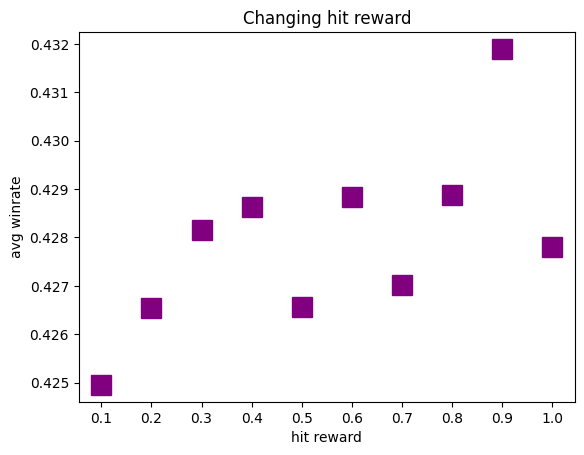

In [28]:
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.plot(labels, wins, 's', c="purple", markersize=15)
plt.xticks(labels)
plt.xlabel("hit reward")
plt.ylabel("avg winrate")
plt.title("Changing hit reward")

### Win Rewards testen (1.0 bis 10.0)

In [29]:
win_reward_envs = []

for i in range(0,10):
    j = 1.0
    j = j + 1.0
    env = BlackjackEnv(sab=True, win_reward=j, lose_reward=-1.0, hit_reward=0.0)
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    win_reward_envs.append(env)

100%|██████████| 100000/100000 [00:10<00:00, 9543.60it/s]


In [30]:
w_wins = []
l = range(1,11)
for env in win_reward_envs:
    i = 0
    win = 0
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state
            if reward == l[i]:
                win += 1
    i = i+1
    w_wins.append(win / n_episodes)

100%|██████████| 100000/100000 [00:09<00:00, 10104.24it/s]


Text(0.5, 1.0, 'Changing win reward')

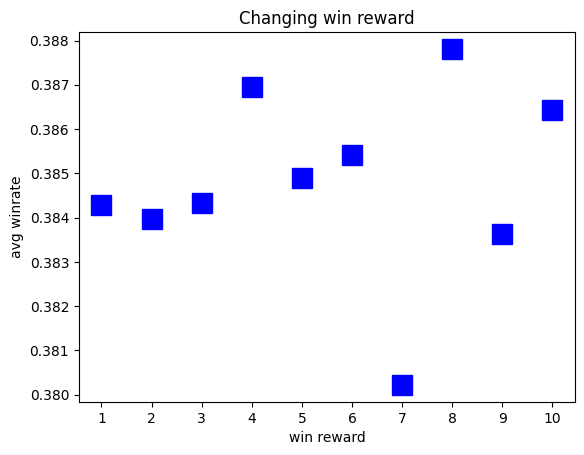

In [31]:
plt.plot(l, w_wins, 's', c="blue", markersize=15)
plt.xticks(l)
plt.xlabel("win reward")
plt.ylabel("avg winrate")
plt.title("Changing win reward")

## Hit und Win Rewards

In [32]:
hits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
w = [1.0, 1.1, 1.2]

hit_win_reward_envs = []

for hit in hits:
    for win in w:
        print(hit)
        print(win)
        env = BlackjackEnv(sab=True, win_reward=win, lose_reward=-1.0, hit_reward=hit)
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        for episode in tqdm(range(100_000)):
            state, info = env.reset()
            done = False

            # play one episode
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)

                # update the agent
                agent.update(state, action, reward, terminated, next_state)

                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state

            agent.decay_epsilon()
        hit_win_reward_envs.append(env)

  1%|          | 892/100000 [00:00<00:11, 8918.39it/s]

0.0
1.0


  2%|▏         | 1806/100000 [00:00<00:10, 9290.51it/s]

0.0
1.1


  2%|▏         | 2089/100000 [00:00<00:09, 10358.14it/s]

0.0
1.2


  1%|          | 941/100000 [00:00<00:10, 9408.86it/s]

0.1
1.0


  1%|          | 1088/100000 [00:00<00:09, 10876.33it/s]

0.1
1.1


  1%|          | 888/100000 [00:00<00:11, 8867.68it/s]

0.1
1.2


  3%|▎         | 2661/100000 [00:00<00:07, 13515.36it/s]

0.2
1.0


  2%|▏         | 2140/100000 [00:00<00:09, 10809.84it/s]

0.2
1.1


  2%|▏         | 1886/100000 [00:00<00:10, 9626.80it/s] 

0.2
1.2


  2%|▏         | 1870/100000 [00:00<00:10, 9190.30it/s]

0.3
1.0


  2%|▏         | 2159/100000 [00:00<00:09, 10809.12it/s]

0.3
1.1


  1%|          | 1012/100000 [00:00<00:09, 10116.25it/s]

0.3
1.2


  1%|          | 1015/100000 [00:00<00:09, 10147.76it/s]

0.4
1.0


  2%|▏         | 2006/100000 [00:00<00:09, 9810.84it/s]

0.4
1.1


  1%|          | 943/100000 [00:00<00:10, 9412.77it/s]

0.4
1.2


  2%|▏         | 1977/100000 [00:00<00:09, 9993.01it/s] 

0.5
1.0


  2%|▏         | 1825/100000 [00:00<00:10, 9142.51it/s]

0.5
1.1


  1%|          | 1154/100000 [00:00<00:08, 11539.87it/s]

0.5
1.2


100%|██████████| 100000/100000 [00:10<00:00, 9447.16it/s]


In [33]:
#hits = [0.0, 0.1, 0.3, 0.6, 0.8, 1.0]
lab_w = [1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 2.0, 2.0, 2.0]

hit_win_wins = []
for env in hit_win_reward_envs:
    i = 0
    win = 0
    for episode in tqdm(range(10_000)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            # update if the environment is done and the current obs
            done = terminated or truncated
            state = next_state
            if reward == lab_w[i]:
                win += 1
    i = i+1
    hit_win_wins.append(win / 10_000)

100%|██████████| 10000/10000 [00:00<00:00, 15025.84it/s]


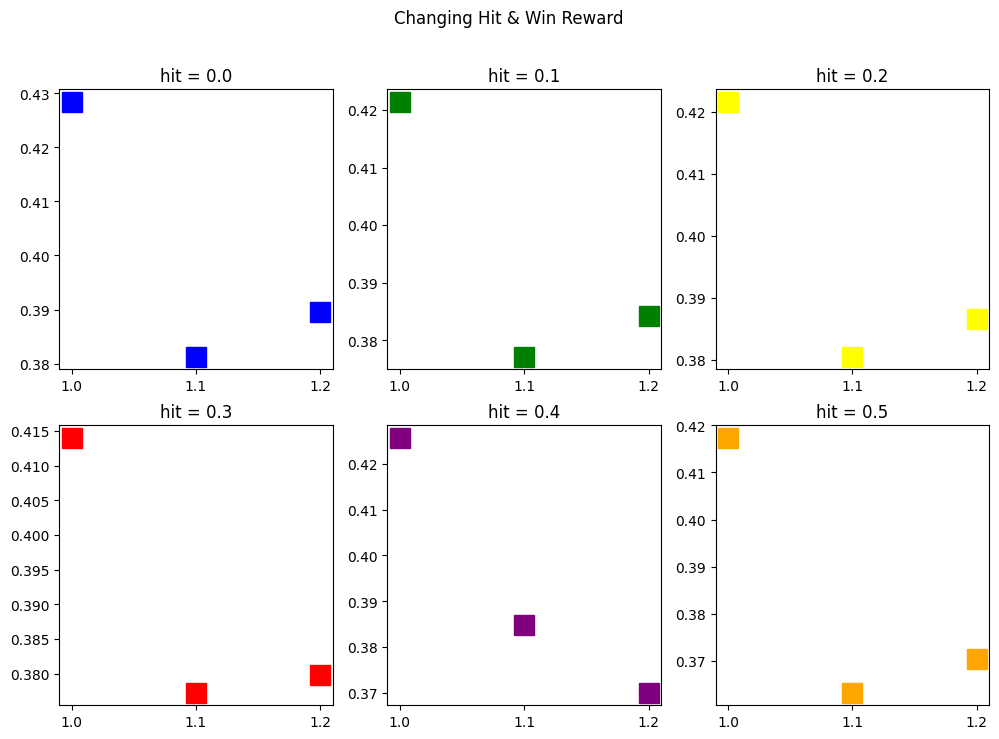

In [34]:
#hits = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#win = [1.0, 1.1, 1.2]

fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(12,8))
fig.suptitle("Changing Hit & Win Reward")

ax[0][0].set_title("hit = 0.0")
ax[0][0].set_xticks([1.0, 1.1, 1.2])
ax[0][0].plot([1.0, 1.1, 1.2], hit_win_wins[:3], 's', c="blue", markersize=15)
ax[0][1].set_xticks([1.0, 1.1, 1.2])
ax[0][1].set_title("hit = 0.1")
ax[0][1].plot([1.0, 1.1, 1.2], hit_win_wins[3:6], 's', c="green", markersize=15)
ax[0][2].set_xticks([1.0, 1.1, 1.2])
ax[0][2].set_title("hit = 0.2")
ax[0][2].plot([1.0, 1.1, 1.2], hit_win_wins[6:9], 's', c="yellow", markersize=15)
ax[1][0].set_xticks([1.0, 1.1, 1.2])
ax[1][0].set_title("hit = 0.3")
ax[1][0].plot([1.0, 1.1, 1.2], hit_win_wins[9:12], 's', c="red", markersize=15)
ax[1][1].set_xticks([1.0, 1.1, 1.2])
ax[1][1].set_title("hit = 0.4")
ax[1][1].plot([1.0, 1.1, 1.2], hit_win_wins[12:15], 's', c="purple", markersize=15)
ax[1][2].set_xticks([1.0, 1.1, 1.2])
ax[1][2].set_title("hit = 0.5")
ax[1][2].plot([1.0, 1.1, 1.2], hit_win_wins[15:], 's', c="orange", markersize=15)